In [11]:
import numpy as np
from tabulate import tabulate
import random
from statistics import mode 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt

dataset link : 
https://iiitaphyd-my.sharepoint.com/:f:/g/personal/apurva_jadhav_students_iiit_ac_in/Eictt5_qmoxNqezgQQiMWeIBph4sxlfA6jWAJNPnV2SF9Q?e=mQmYN0 

                

In [12]:
x_l = np.load("X.npy") # image
y_l = np.load("Y.npy") # label

In [25]:
class LogitsicRegression():
    def __init__(self,iteration=1000,alpha=0.001):
        self.iteration = iteration
        self.alpha = alpha
        self.multimodel = 'ovo'
        self.weights = None
        self.combinations = None
        self.cost = None
        
    def sigmoid(self,x):
        return 1/(1+np.exp(-x))
    
    def __cost_function__(self,y,y_pred,m):
        return -(np.sum(y*np.log(y_pred)+(1-y)*np.log(1-y_pred)))/m
        
    def __fitHelper__(self,X,y):
        samples, features = X.shape
        temp = 0.01
        weights = np.repeat(temp,(features))
        bias = temp
        cost = []
        
        for i in range(self.iteration):
            temp = np.dot(X,weights) + bias
            predicted = self.sigmoid(temp)
            
            cost.append(self.__cost_function__(y,predicted,samples))
            
            dw = (np.dot(X.T,(predicted-y)))/samples
            db = (np.sum(predicted-y))/samples
            
            weights -= self.alpha*dw
            bias -= self.alpha*db
        
        self.cost = cost
         
        return [weights,bias]
    
    def __fit_ovr__(self,X,y):
        _, lables = y.shape
        weights = []
        for i in range(0,lables):
            weights.append(self.__fitHelper__(X,y[:,i]))
        
        self.weights = np.array(weights)
        
    def __predict_ovr__(self,X):
        lables, _ = self.weights.shape
        predictions = []
        for i in range(0,lables):
            temp = np.dot(X,self.weights[i][0]) + self.weights[i][1]
            predictions.append(self.sigmoid(temp))
            
        predictions = np.array(predictions)
        b = np.zeros_like(predictions.T)
        b[np.arange(len(predictions.T)), predictions.T.argmax(1)] = 1
        return b
            
    def __fit_ovo__(self,X,y):
        _, lables = y.shape
        weights = []
        combinations = []
        for i in range(0,lables):
            for j in range(i+1,lables):
                combinations.append([i,j])
                x1 = (y[:,i]==1) 
                y1 = (y[:,j]==1)
                X_train = X[np.logical_or(x1,y1)]
                y_train = y[np.logical_or(x1,y1)]
                weights.append(self.__fitHelper__(X_train,y_train[:,j]))
        
        self.weights = np.array(weights)
        self.combinations = np.array(combinations)
    
    def __predict_ovo__(self,X):
        lables,_ = self.weights.shape
        predictions = []
        for i in range(0,lables):
            temp = np.dot(X,self.weights[i][0]) + self.weights[i][1]
            s = self.sigmoid(temp)
            pred = [self.combinations[i][1] if k>0.5 else self.combinations[i][0] for k in s]
            predictions.append(pred)
        
        predictions = np.array(predictions).T
        lables = []
        for i in range(len(X)):
            lables.append(np.bincount(predictions[i]).argmax())
            
        return np.array(lables)                
    
    def fit(self,X,y,multimodel='ovo'):
        self.multimodel = multimodel
        if(multimodel=="ovo"):
            self.__fit_ovo__(X,y)
        else:
            self.__fit_ovr__(X,y)
        
    def predict(self,X):
        if self.multimodel == 'ovo':
            return self.__predict_ovo__(X)
        else:
            return self.__predict_ovr__(X)

# Splitting the data randomly

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_l, y_l, test_size = 0.3, random_state = 42)

In [27]:
r,c,p = X_train.shape
X_train = X_train.reshape(r,c*p)
r,c,p = X_test.shape
X_test = X_test.reshape(r,c*p)

In [28]:
ys = np.argmax(y_test,axis=1)
ys_train = np.argmax(y_train,axis=1)

## Diagram for sigmoid function

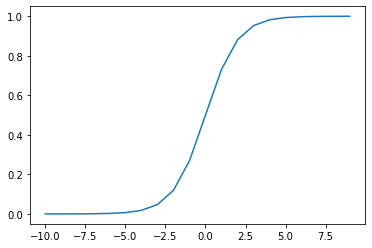

In [29]:
values = []
for i in range(-10,10):
    values.append(i)
    
sigmoid_values = []
lg = LogitsicRegression()
for i in range(0,len(values)):
    sigmoid_values.append(lg.sigmoid(values[i]))
    
plt.plot(values,sigmoid_values)
plt.show()

__Observation__

- From the above graph we can set a threshold and see if the sigmoid value is >threshold we assign one lable and if the sigmoid value is <= threshold we assign othee lable. This can only be used for binary classification.

Below we will see the methods to extend this for multiple lables

#### Methods for multi-lable classification using logistic regression

1) __One vs All__

- Splits a multi-class classification into one binary classification problem per class
- It involves splitting the multi-class dataset into multiple binary classification problems
- A binary classifier is then traines on each binary classification problem and predictions ar emade using the model that is the mos confident
</br>
- __Example__ : Let us consider the problem of predicting the color of the car (red,yellow,blue)
    - As we have 3 lable we will have 3 models that has to be trained. The 3 models are as follows:
    - Binary classifier problem 1 : red vs [blue,yellow]
    - Binary classifier problem 2 : blue vs [red,yellow]
    - Binary classifier problem 3 : yellow vs [red,blue]
</br>
- This approach requires that each model predicts a class membership probability or a probability-like score. the argmax of these scores (class index with the largest score) is then used to predict a class
- The downside of this approach is that it requires one mdodel to be created for each class. For exmaple, 3 classes requires 3 models.
- This could be a problem for large datasets, slor models, or very large number of classes.

2) __One vs One__

- Splits a multi-class classification into one binary classification problem per each pair of classes
- __Example__ : Consider the problem of predicting the color of a car(red,yellow,blue,green)
    - Binary Classification problem 1 : red vs blue
    - Binary Classification problem 2 : red vs yellow
    - Binary Classification problem 3 : blue vs yellow
    - Binary Classification problem 4 : blue vs green
    - Binary Classification problem 5 : red vs green
    - Binary Classification problem 6 : yellow vs green

- There will be C(n,2) models that has to be trained, where n is the number of lables
- Each binary classifier model may predict one class bael and the model with the most predictions or votes is predicted by the one-s-one strategy

### One-vs-all method

In [30]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
lg = LogitsicRegression(iteration=1000,alpha=0.01)
lg.fit(X_train,y_train,multimodel='ovr')

In [31]:
prediction_ovr = lg.predict(X_test)

In [32]:
ovr_accuracy = accuracy_score(y_test,prediction_ovr)
print(ovr_accuracy)

0.7092084006462036


In [33]:
## Converting the 2D arrya of lables into 1D
prediction_ovr_converted = np.argmax(prediction_ovr,axis=1)

In [34]:
CM_ovr = confusion_matrix(ys, prediction_ovr_converted)
print(CM_ovr)

[[50  1  0  0  0  0  2  0  0  2]
 [ 0 57  0  3  3  2  5  0  0  0]
 [ 1  2 50  2  8  4  3  0  6  0]
 [ 0  3  4 45  1  3  2  0  5  0]
 [ 0  4  0  1 40  4  0  2  0  1]
 [ 4  1  4  1  2 39  0  0  2  2]
 [ 3  2 11 11  1  9 21  0  2  5]
 [ 5  0  1  0  2  0  0 50  3  1]
 [ 0  3  7  4  8  1  0  2 35  0]
 [ 1  0  1  0  0  1  3  3  0 52]]


### One-vs-One method

In [59]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
lg1 = LogitsicRegression(iteration=1000,alpha=0.01)

lg1.fit(X_train,y_train,multimodel='ovo')

In [60]:
prediction_ovo = lg1.predict(X_test)

In [64]:
ovo_accuracy = accuracy_score(ys,prediction_ovo)
print(ovo_accuracy)

0.7560581583198708


In [63]:
CM_ovo = confusion_matrix(ys, prediction_ovo)
print(CM_ovo)

[[52  1  0  0  0  0  1  0  0  1]
 [ 0 61  1  2  1  1  3  0  1  0]
 [ 0  1 55  2  5  5  2  0  6  0]
 [ 0  2  6 38  1  1 10  0  5  0]
 [ 1  4  1  1 40  3  0  1  0  1]
 [ 2  1  6  0  1 42  0  0  2  1]
 [ 1  2 16  1  0  3 35  0  3  4]
 [ 2  0  1  0  1  0  1 54  2  1]
 [ 0  1  7  3  7  0  0  3 39  0]
 [ 2  0  0  0  0  0  2  5  0 52]]


### Scikit-learn log reg 

In [66]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(multi_class='ovr',solver='liblinear').fit(X_train, ys_train)
prediction_inbuilt = clf.predict(X_test)

log_reg_accuracy = accuracy_score(ys,prediction_inbuilt)

In [69]:
tabuler_data = [["One vs all",ovr_accuracy],["One-vs-one",ovo_accuracy],["Log Reg(Scikit-learn)",log_reg_accuracy]]
print(tabulate(tabuler_data, headers=['Methods','Accuracy'], tablefmt='orgtbl'))

| Methods               |   Accuracy |
|-----------------------+------------|
| One vs all            |   0.709208 |
| One-vs-one            |   0.756058 |
| Log Reg(Scikit-learn) |   0.731826 |


## Displaying the actual vs predicted lables

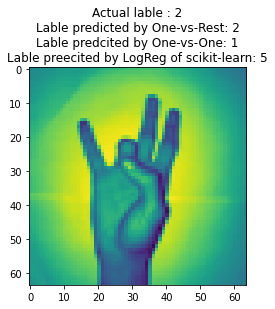

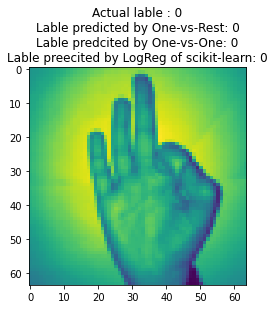

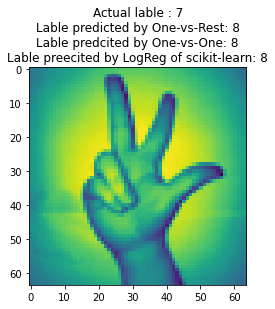

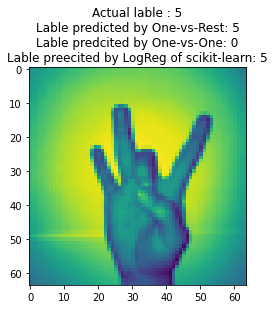

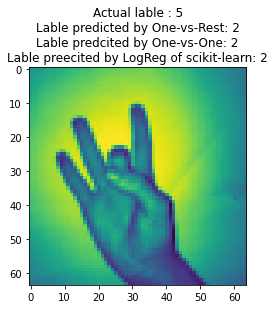

In [95]:
no_of_images = 5
indexes = []

for i in range(no_of_images):
    index = (random.randint(0, len(X_test)))
    image = np.reshape(X_test[index], (64, 64)) 
    plt.imshow(image)
    plt.title("Actual lable : "+str(ys[index])+"\n"+
              "Lable predicted by One-vs-One: "+str(prediction_ovo[index])+"\n"+
              "Lable predcited by One-vs-Rest: "+str(prediction_ovr_converted[index])+"\n"+
              "Lable preecited by LogReg of scikit-learn: "+str(prediction_inbuilt[index]))
    plt.show()

__Observations__:

- Some of the lables are predicted correctly 
- As the model is not 100% accurate some of the lables predicted varies for each model
- Also, there is an observation that the representation of same picture is labled differently 
- This sometimes confuses the model as for the same values we have different labels
- This could also be the reason why the some labels are predcited different from original